# Uber Traffic Network Analysis

## Import packages and load data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import nxviz as nv
import matplotlib.pyplot as plt

from utils import load_data
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

C:\Users\Win 10\AppData\Roaming\Python\Python310\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [34]:
node_dict = {}
edge_dict = {}

G = load_data.load_uber_traffic_network(node_dict, edge_dict)

## Visualization

In [35]:
# nx.draw(G)

## Basic statistics on graph

In [36]:
Gcc = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)

print("Number of nodes are:", nx.number_of_nodes(Gcc))
print("Number of edges are:", nx.number_of_edges(Gcc))

Number of nodes are: 1898
Number of edges are: 321703


## Traveling salesman problem
On this problem, we used the 2-approximation algorithm.

### Step 1: Check for triangle inequality

In [37]:
import random

bound = max(node_dict.keys())
sample_num = 0
triangle_num = 0
used = set()

while sample_num < 1000:
    v1 = random.randint(1, bound)
    v2 = random.randint(1, bound)
    v3 = random.randint(1, bound)
    
    if (v1 != v2 != v3) \
        and (v1, v2) in edge_dict and (v2, v3) in edge_dict and (v3, v1) in edge_dict and \
            (v1, v2, v3) not in used:
        used.add((v1, v2, v3))
        sample_num += 1
    
        d12 = edge_dict[(v1, v2)][0] / edge_dict[(v1, v2)][1]
        d23 = edge_dict[(v2, v3)][0] / edge_dict[(v2, v3)][1]
        d31 = edge_dict[(v3, v1)][0] / edge_dict[(v3, v1)][1]
        
        if (d12 + d23 > d31) and (d23 + d31 > d12) and (d12 + d31 > d23):
            triangle_num += 1

print("The percentage of triangles in the graph is", triangle_num/sample_num * 100)

The percentage of triangles in the graph is 93.30000000000001


### Step 2: Build a minimum spannning tree

In [38]:
MST = nx.minimum_spanning_tree(Gcc, algorithm='kruskal')

In [39]:
for point in sorted(list(nx.edges(MST))[0:5]):
    print(node_dict[point[0]]["DISPLAY_NAME"], "----", node_dict[point[1]]["DISPLAY_NAME"])

400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 1500 Oxford Street, Palm Park, Redwood City
400 Northumberland Avenue, Redwood Oaks, Redwood City ---- 100 Fifth Avenue, South Fair Oaks, Redwood City
18300 Sutter Boulevard, Morgan Hill ---- 17300 Lotus Way, Morgan Hill
18300 Sutter Boulevard, Morgan Hill ---- 1900 Alpet Drive, Morgan Hill
3200 Huntsman Drive, Rosemont Park, Sacramento ---- 8900 Cal Center Drive, Sacramento


### Step 3: Build a multi graph

In [40]:
multi_G = nx.MultiGraph()
multi_G.add_nodes_from(MST)
path = []

for edge in MST.edges:
    w = MST.edges[edge]['weight']
    multi_G.add_edge(edge[0], edge[1], weight=w)
    multi_G.add_edge(edge[1], edge[0], weight=w)

### Step 4: Find an Eulerian closed-walk and an embedded tour

In [41]:
Euler_circle = nx.eulerian_circuit(multi_G)

travel_length = 0
idx = 0

for edge in Euler_circle:
    if idx == 0:
        start = edge[0]
    if edge[1] == start:
        # print(edge[0])
        dst = edge[0]
        path.append(dst)
        # print('-'*30)
        break
    travel_length += multi_G.edges[edge[0], edge[1], 0]['weight']
    path.append(edge[0])
    # print(edge[0], "->", end=' ')
    idx += 1

print("Approximate TSP cost is:", travel_length)

Approximate TSP cost is: 440276.2400000001


### Step 5: Estimate the performance

In [42]:
opt_length = 0

for edge in MST.edges:
    opt_length += MST.edges[edge]['weight']

print("The upper bound on the empirical performance of the approximation algorithm is", travel_length/opt_length)

The upper bound on the empirical performance of the approximation algorithm is 1.5217849499512972


### Step 6: Plot the trajectory

Text(0.5, 1.0, 'The trajectory')

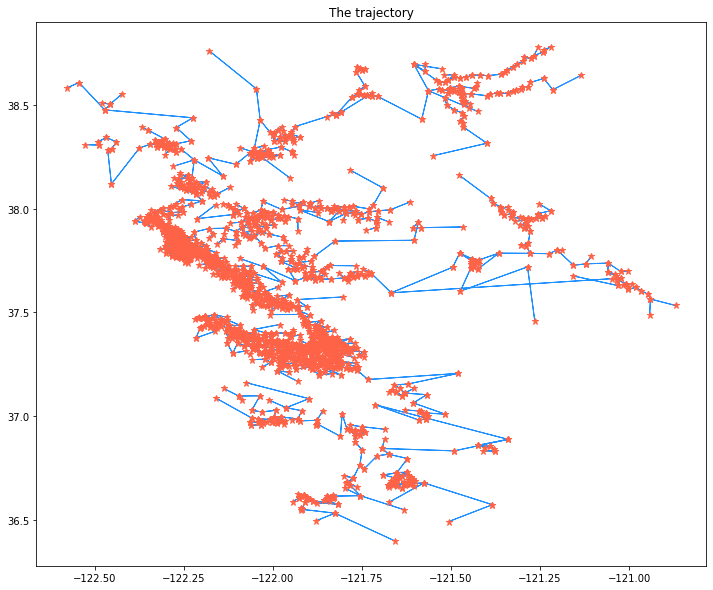

In [46]:
X = []  # longitude
Y = []  # lattitude

for node in path:
    X.append(node_dict[node]['Location'][0])
    Y.append(node_dict[node]['Location'][1])

# plot the trajectory
plt.figure(figsize=(12, 10))
plt.plot(X, Y, linewidth=1, color='dodgerblue')
plt.plot(X, Y, '*', markersize=7, color='tomato')
plt.title('The trajectory')

## Map generalization
Plot the road mesh obtain by delaunay triangulation

In [12]:
from scipy.spatial import Delaunay

nums_of_area = len(node_dict)
vertices = nx.nodes(Gcc)
mean_coordinates = np.array([elm['Location'] for elm in list(node_dict.values())])
mean_coordinates_gcc = mean_coordinates[[x-1 for x in vertices], :]
triangulation = Delaunay(mean_coordinates_gcc)

Text(0.5, 1.0, 'Road mesh by delaunay triangulation')

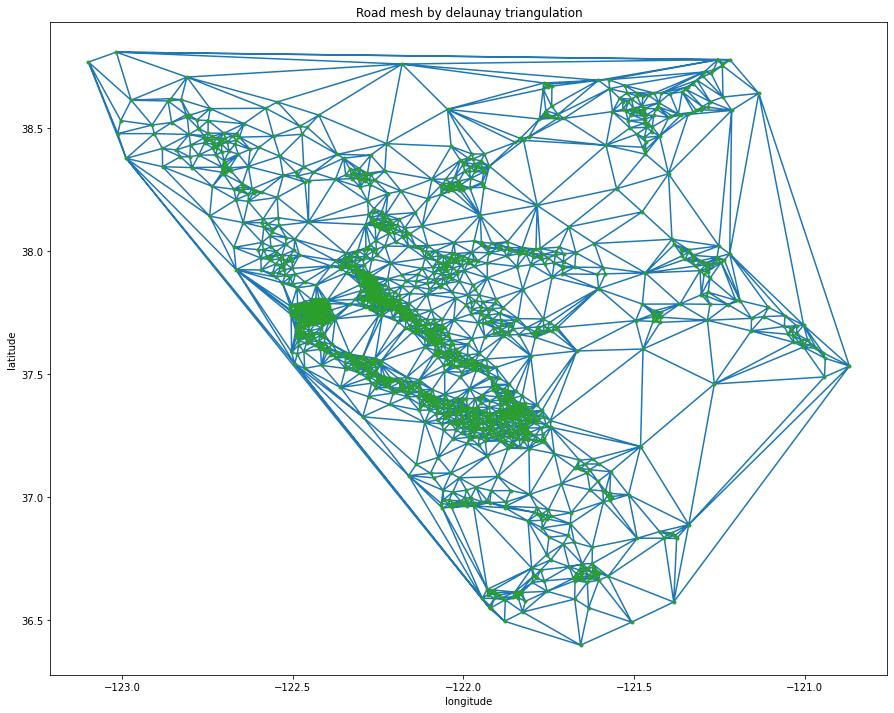

In [13]:
plt.figure(figsize=(15, 12))
plt.triplot(mean_coordinates_gcc[:, 0], mean_coordinates_gcc[:, 1], triangulation.simplices)
plt.plot(mean_coordinates_gcc[:, 0], mean_coordinates_gcc[:, 1], '.')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Road mesh by delaunay triangulation')

In [14]:
G_delta = nx.Graph()

used_nodes = triangulation.simplices
edges_delta = set()

for row in range(used_nodes.shape[0]):
    for idx in range(3):
        node1 = list(vertices)[used_nodes[row][idx]]
        node2 = list(vertices)[used_nodes[row][(idx+1) % 3]]
        if (node1, node2) not in edges_delta and (node2, node1) not in edges_delta:
            edges_delta.add((node1, node2))
            G_delta.add_edge(node1, node2)

print("Number of nodes in G_delta is", nx.number_of_nodes(G_delta))
print("Number of edges in G_delta is", nx.number_of_edges(G_delta))

Number of nodes in G_delta is 1898
Number of edges in G_delta is 5680


## Calculate road traffic flows

Consider the following assumption

+ Each degree of latitude and longitude $\approx$ 69 miles
+ Car length $\approx$ 5 m $\approx$ 0.003 mile
+ Cars maintain a safety distance of 2 seconds to the next car
+ Each road has 2 lanes in each direction

Assuming no traffic jam, consider the calculated traffic flow as the max capacity of each road. Calculate the traffic flow for each road in terms of cars/hour.

In [15]:
miles_per_degree = 69
car_length = 0.003
safe_time = 2/3600
lanes = 2
traffic_flow = {}
fake_flow = []

edges_delta = nx.edges(G_delta)
for edge in list(edges_delta):
    u = edge[0]
    v = edge[1]

    mean_time = 1e8     # threshold
    if (u, v) in edge_dict:
        mean_time = edge_dict[(u,v)][0] / edge_dict[(u,v)][1]
    elif (v, u) in edge_dict:
        mean_time = edge_dict[(v,u)][0] / edge_dict[(v,u)][1]

    miles = np.sqrt(
        np.square(abs(node_dict[u]['Location'][0] - node_dict[v]['Location'][0]) * miles_per_degree) +
        np.square(abs(node_dict[u]['Location'][1] - node_dict[v]['Location'][1]) * miles_per_degree)
    )

    car_speed = miles / (mean_time/3600)
    safety_distance = car_speed * safe_time
    car_flow = (car_speed / (car_length + safety_distance)) * lanes

    G_delta.add_edge(u, v, capacity=car_flow)
    traffic_flow[(u,v)] = car_flow
    if mean_time == 1e8:
        fake_flow.append(car_flow)

fake_flow_threshold = max(fake_flow)
print("The fake flow are all under", fake_flow_threshold)
print("Number of fake flows are:", len(fake_flow))

The fake flow are all under 3.502789189460015
Number of fake flows are: 392


In [16]:
from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

n_roads = take(5, traffic_flow.items())
for i in range(len(n_roads)):
    print(f"{n_roads[i][0]}: {n_roads[i][1]}")

(1444, 2017): 0.5261317608739441
(1444, 583): 1.3213564449322088
(1444, 1231): 1.1921773439325514
(1444, 793): 0.954980147325594
(1444, 38): 3324.9516604562614


## The Max Flow

Consider the following address:
+ Source address: 100 Campus Drive, Stanford
+ Destination address: 700 Meder Street, Santa Cruz

We want to calculate the maximum number of cars that can commute per hour from Stanford to UCSC. And also calculate the number of edge-disjoint paths between the two spots.

### Step 1: Determine the ID of Stanford and UCSC

In [17]:
Stanford_ID = 0
UCSC_ID = 0

for key in node_dict:
    if node_dict[key]['DISPLAY_NAME'] == '100 Campus Drive, Stanford':
        Stanford_ID = key
        print("Stanford node is", Stanford_ID)
    elif node_dict[key]['DISPLAY_NAME'] == '700 Meder Street, Santa Cruz':
        UCSC_ID = key
        print("UCSC node is", UCSC_ID)

UCSC node is 1968
Stanford node is 2607


### Step 2: Calculate the max flow between Stanford and UCSC

In [18]:
flow_value, flow_dict = nx.maximum_flow(G_delta, UCSC_ID, Stanford_ID)
print("The maximum flow between Stanford and UCSC is", flow_value)

The maximum flow between Stanford and UCSC is 14866.477294089982


### Step 3: Find edge disjoint paths

In [19]:
edge_disjoint_paths = nx.edge_disjoint_paths(G_delta, UCSC_ID, Stanford_ID)

count = 0
for path in edge_disjoint_paths:
    count += 1
    print(path)
print("Number of edge-disjoint path is", count)

[1968, 2241, 1980, 2242, 744, 1869, 1363, 2240, 2607]
[1968, 1424, 1431, 1980, 1763, 1762, 1209, 1733, 1725, 2607]
[1968, 1431, 1989, 938, 744, 1737, 1736, 1726, 2607]
[1968, 748, 2241, 1171, 1955, 1763, 1737, 1363, 2607]
[1968, 1980, 1955, 2458, 1210, 1762, 1736, 2607]
Number of edge-disjoint path is 5


### Step 4: Visualize Stanford and UCSC location

In [20]:
Stanford_loc = node_dict[Stanford_ID]['Location']
UCSC_loc     = node_dict[UCSC_ID]['Location']

print("Stanford location:", Stanford_loc[0], Stanford_loc[1])
print("UCSC location:", UCSC_loc[0], UCSC_loc[1])

Stanford location: -122.1759822222222 37.42968588888888
UCSC location: -122.06456181081083 36.97416881081081


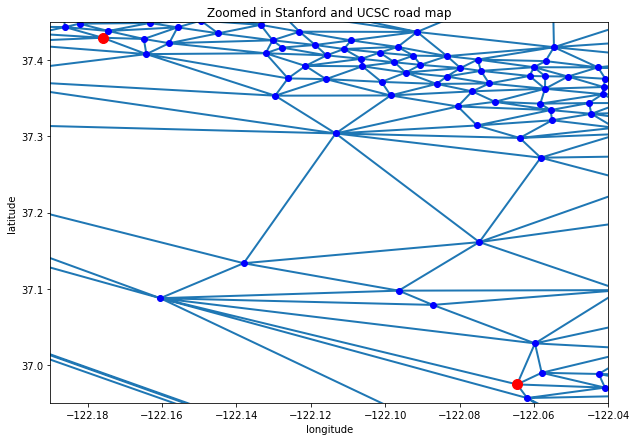

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(Stanford_loc[0], Stanford_loc[1], 'o', color='red', markersize=10)
plt.plot(UCSC_loc[0], UCSC_loc[1], 'o', color='red', markersize=10)

for node in node_dict:
    if node != Stanford_ID and node != UCSC_ID:
        plt.plot(node_dict[node]['Location'][0], node_dict[node]['Location'][1], 'o', color='blue')

plt.triplot(mean_coordinates_gcc[:, 0], mean_coordinates_gcc[:, 1], triangulation.simplices, lw=2.0)
plt.xlim(-122.19, -122.04)
plt.ylim(36.95, 37.45)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed in Stanford and UCSC road map')
plt.show()

## Optimize the Road Map

As we can see, there are a number of unreal roads in $G_\Delta$ that could be removed. For instance, there are many fake bridges crossing the bay. We can apply a threshold on the travel time of the roads in $G_\Delta$ to remove the fake edges. After trimming the fake edges, we will have the $\tilde{G}_\Delta$. We actually don't want the real edges to be disappear. So, consider these following real edges (or bridges):
+ Golden Gate Bridge: [[-122.475, 37.806], [-122.479, 37.83]]
+ Richmond, San Rafael Bridge: [[-122.501, 37.956], [-122.387, 37.93]]
+ San Mateo Bridge: [[-122.273, 37.563], [-122.122, 37.627]]
+ Dambarton Bridge: [[-122.142, 37.486], [-122.067, 37.54]]
+ San Francisco - Oakland Bay Bridge: [[-122.388, 37.788], [-122.302, 37.825]]

### Step 1: Trim $G_\Delta$ and create $\tilde{G}_\Delta$

In [22]:
G_tilde = nx.Graph()
G_tilde.add_nodes_from(G_delta)

fake_flow_threshold = 5
for edge in G_delta.edges():
    capacity = G_delta.edges[edge]['capacity']
    if capacity <= fake_flow_threshold:
        continue
    G_tilde.add_edge(edge[0], edge[1], capacity=capacity)

print("Number of edges in trimmed graph is", nx.number_of_edges(G_tilde))

Number of edges in trimmed graph is 5288


### Step 2: Determine the exact location of bridges

In [23]:
GGB   = np.array([[-122.475, 37.806], [-122.479, 37.83]])
RSRB  = np.array([[-122.501, 37.956], [-122.387, 37.93]])
SMB   = np.array([[-122.273, 37.563], [-122.122, 37.627]])
DB    = np.array([[-122.142, 37.486], [-122.067, 37.54]])
SFOBB = np.array([[-122.388, 37.788], [-122.302, 37.825]])

bridges = [GGB, RSRB, SMB, DB, SFOBB]
bridge_on_map = []

def get_nearest_node(target, node_list):
    distances = []
    for i in range(len(node_list)):
        x = node_dict[node_list[i]]['Location'][0]
        y = node_dict[node_list[i]]['Location'][1]
        dist = (target[0]-x)**2 + (target[1]-y)**2
        distances.append(dist)
    return node_list[np.argsort(distances)[0]]

for i in range(len(bridges)):
    road = bridges[i]
    near_node1 = []
    near_node2 = []
    for node in node_dict:
        x = node_dict[node]['Location'][0]
        y = node_dict[node]['Location'][1]
        if round(road[0, 0], 1) == round(x, 1) and round(road[0, 1], 1) == round(y, 1):
            near_node1.append(node)
        if round(road[1, 0], 1) == round(x, 1) and round(road[1, 1], 1) == round(y, 1):
            near_node2.append(node)
    node1 = get_nearest_node(road[0, :], near_node1)
    node2 = get_nearest_node(road[1, :], near_node2)
    bridge_on_map.append((node1, node2))

### Step 3: Visualize the bridges

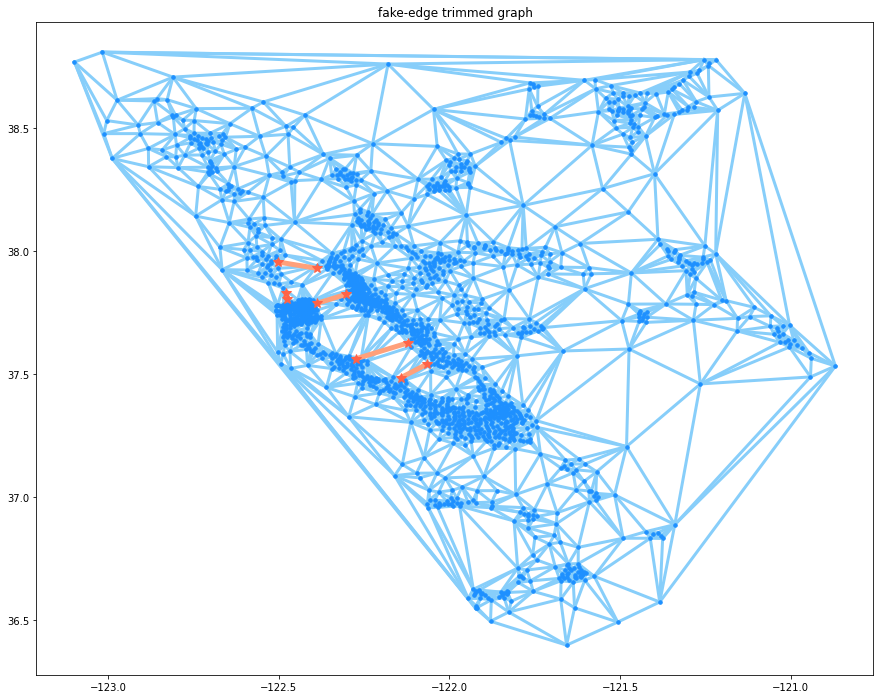

In [24]:
plt.figure(figsize=(15, 12))

for edge in G_delta.edges:
    x = [node_dict[edge[0]]['Location'][0], node_dict[edge[1]]['Location'][0]]
    y = [node_dict[edge[0]]['Location'][1], node_dict[edge[1]]['Location'][1]]
    plt.plot(x, y, linewidth=3, color='lightskyblue')

for node in G_delta.nodes:
    plt.plot(node_dict[node]['Location'][0], node_dict[node]['Location'][1], '.', markersize=7, color='dodgerblue')

for road in bridges:
    x = [road[0, 0], road[1, 0]]
    y = [road[0, 1], road[1, 1]]
    plt.plot(x, y, linewidth=5, color='lightsalmon')
    plt.plot(x, y, '*', markersize=10, color='tomato')

plt.title("fake-edge trimmed graph")
plt.show()

In [25]:
flow_value, flow_dict = nx.maximum_flow(G_tilde, UCSC_ID, Stanford_ID)
print("Max flow is:", flow_value)

Max flow is: 14866.477294089984


In [26]:
edge_disjoint_paths = nx.edge_disjoint_paths(G_tilde, UCSC_ID, Stanford_ID)
count = 0
for i in edge_disjoint_paths:
    count += 1
    print(i)
    
print("The number of edge-disjoint paths are:", count)

[1968, 2241, 1980, 2528, 2242, 938, 1947, 2656, 829, 931, 2222, 2223, 1357, 1853, 1848, 1849, 1850, 1358, 1852, 743, 2378, 2607]
[1968, 1424, 239, 1432, 1989, 1934, 2596, 1936, 725, 2656, 1948, 2490, 2223, 1853, 1849, 1361, 1363, 2240, 2607]
[1968, 1431, 1981, 2528, 938, 2221, 725, 1947, 1948, 744, 1853, 1869, 1363, 2607]
[1968, 748, 1424, 1431, 1989, 938, 744, 1869, 1737, 1736, 1726, 2607]
[1968, 1980, 1431, 1432, 2232, 1934, 2221, 1947, 744, 1737, 1363, 1736, 2607]
The number of edge-disjoint paths are: 5


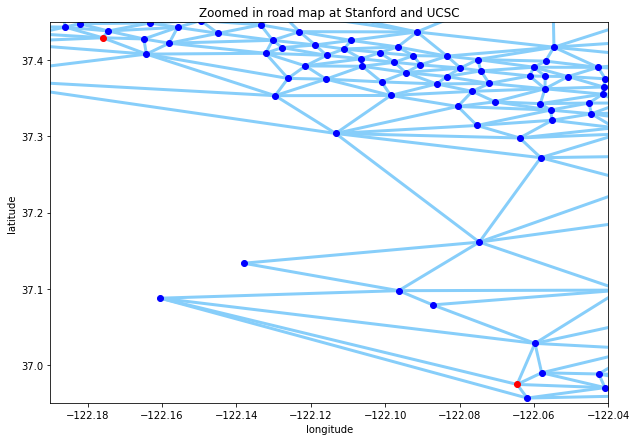

In [27]:
plt.figure(figsize=(10, 7))
for edge in G_tilde.edges:
    x = [node_dict[edge[0]]['Location'][0], node_dict[edge[1]]['Location'][0]]
    y = [node_dict[edge[0]]['Location'][1], node_dict[edge[1]]['Location'][1]]
    plt.plot(x, y, linewidth=3, color='lightskyblue')

plt.plot(Stanford_loc[0], Stanford_loc[1], 'o', color='red')
plt.plot(UCSC_loc[0], UCSC_loc[1], 'o', color='red')

for node in node_dict:
    if node != Stanford_ID and node != UCSC_ID:
        plt.plot(node_dict[node]['Location'][0], node_dict[node]['Location'][1], 'o', color='blue')
plt.xlim(-122.19, -122.04)
plt.ylim(36.95, 37.45)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Zoomed in road map at Stanford and UCSC')
plt.show()